# UNet


Przygotowanie danych 

In [35]:
import os
from pathlib import Path

input_dir = Path(r"/home/plorenc/Desktop/AiR_ISS/ML/lab9/images")
target_dir = Path("/home/plorenc/Desktop/AiR_ISS/ML/lab9/annotations/trimaps")
#img_size = #
#num_classes = # Object, background, uncertain area between
#batch_size = 32
#input_img_paths = # folder + file path
#target_img_paths = 

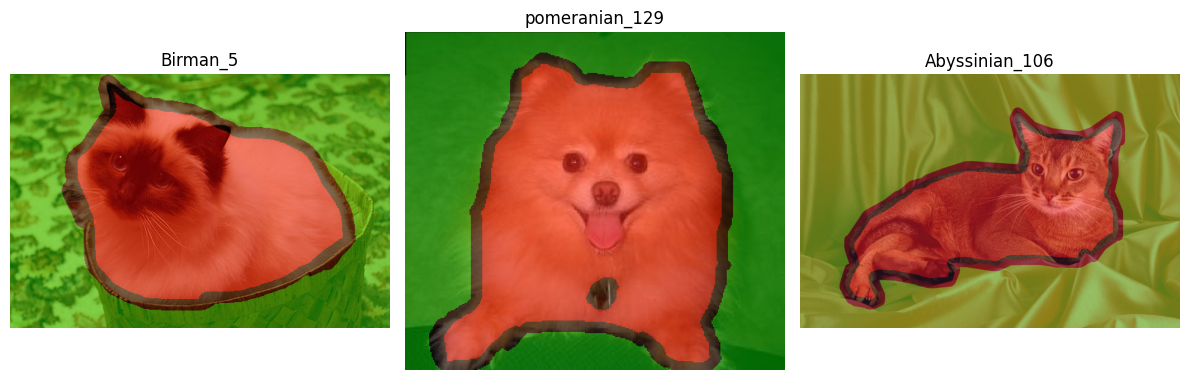

In [36]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from pathlib import Path

input_dir = Path("/home/plorenc/Desktop/AiR_ISS/ML/lab9/images")
target_dir = Path("/home/plorenc/Desktop/AiR_ISS/ML/lab9/annotations/trimaps")

input_files = sorted([p for p in input_dir.glob("*.jpg") if not p.name.startswith('.')])
target_files = sorted([p for p in target_dir.glob("*.png") if not p.name.startswith('.')])

image_map = {p.stem: p for p in input_files}
mask_map = {p.stem: p for p in target_files}

common_keys = list(set(image_map.keys()) & set(mask_map.keys()))

samples = random.sample(common_keys, 3)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, key in enumerate(samples):
    img_path = image_map[key]
    mask_path = mask_map[key]

    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    mask_rgb[mask == 1] = [255, 0, 0]
    mask_rgb[mask == 2] = [0, 255, 0]

    axs[i].imshow(img)
    axs[i].imshow(mask_rgb, alpha=0.4)
    axs[i].axis('off')
    axs[i].set_title(key)

plt.tight_layout()
plt.show()


Klasa z datasetem

In [37]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import Sequence


class DataGen(Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, input_target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.input_target_paths = input_target_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def load_and_process_img(self, path):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_size)
        img = img.astype("float32") / 255.0
        return img
        

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_paths = self.input_img_paths[i:i + self.batch_size]
        batch_target_paths = self.input_target_paths[i:i + self.batch_size]

        X = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")
        y = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        for j, (img_path, target_path) in enumerate(zip(batch_input_paths, batch_target_paths)):
            X[j] = self.load_and_process_img(img_path)
            y[j] = self.load_and_process_img(target_path)

        return X, y

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    input_files, target_files, test_size=0.2, random_state=42
)

train_dataloder = DataGen(batch_size=32, img_size=(128, 128), input_img_paths=X_train, input_target_paths=Y_train)
test_dataloder = DataGen(batch_size=32, img_size=(128, 128), input_img_paths=X_test, input_target_paths=Y_test)

In [39]:
next(iter(train_dataloder))[1][1].shape

(128, 128, 3)

### Inplementacja Uneta 

In [40]:
import tensorflow as tf
from keras import layers

class DoubleConv(tf.keras.Model):
    def __init__(self, num_filters):
        super(DoubleConv, self).__init__()
        self.conv1 = layers.Conv2D(num_filters, 3, activation='relu', padding='same')
        self.conv2 = layers.Conv2D(num_filters, 3, activation='relu', padding='same')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return x


class DownsampleBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DownsampleBlock, self).__init__()
        self.double_conv = DoubleConv(num_filters)
        self.maxpool = layers.MaxPool2D((2, 2))
        self.drop = layers.Dropout(0.2)

    def call(self, inputs):
        x = self.double_conv(inputs)
        p = self.maxpool(x)
        p = self.drop(p)
        return x, p


class UpsampleBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(UpsampleBlock, self).__init__()
        self.upconv = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.double_conv = DoubleConv(num_filters)
        self.drop = layers.Dropout(0.2)

    def call(self, inputs, skip_features):
        x = self.upconv(inputs)
        x = tf.concat([x, skip_features], axis=-1)
        x = self.drop(x)
        x = self.double_conv(x)
        return x


class UNet(tf.keras.Model):
    def __init__(self, img_size, num_classes):
        super(UNet, self).__init__()
        self.down1 = DownsampleBlock(64)
        self.down2 = DownsampleBlock(128)
        self.down3 = DownsampleBlock(256)
        self.down4 = DownsampleBlock(512)

        self.bottleneck = DoubleConv(1024)

        self.up4 = UpsampleBlock(512)
        self.up3 = UpsampleBlock(256)
        self.up2 = UpsampleBlock(128)
        self.up1 = UpsampleBlock(64)

        self.classifier = layers.Conv2D(num_classes, 1, activation='softmax')

    def call(self, inputs):
        # Downsampling path
        f1, p1 = self.down1(inputs)
        f2, p2 = self.down2(p1)
        f3, p3 = self.down3(p2)
        f4, p4 = self.down4(p3)

        # Bottleneck
        bottleneck = self.bottleneck(p4)

        # Upsampling path
        u4 = self.up4(bottleneck, f4)
        u3 = self.up3(u4, f3)
        u2 = self.up2(u3, f2)
        u1 = self.up1(u2, f1)

        # Output layer
        outputs = self.classifier(u1)  # num_classes = 2
        return outputs


In [41]:
unet = UNet((128, 128), 3)

unet.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [42]:
BATCH_SIZE = 128
EPOCHS = 50

'''
unet.fit(
    train_dataloder,
    validation_data=test_dataloder,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
)
'''

'\nunet.fit(\n    train_dataloder,\n    validation_data=test_dataloder,\n    batch_size = BATCH_SIZE,\n    epochs = EPOCHS,\n)\n'